# <center>Time Series Forecasting Using Artificial Neural Networks</center>

- In this Poject, we will apply Neural Networks on Time Series data to forecast.
- Some of the techniques/variants of NN that are applied on time series are:
    - Feed forward Neural Networks(FNN)
    - Time lagged Neural Networks(TLNN)
    - Seasonal Artificial Neural Networks(SANN)
    - Long Short Term Memory(LSTM)
    
- Data used for the experiments is "Pune Precipitation data from 1965 to 2002".

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import re,math,itertools,urllib.request
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
filename = 'Dallas_weather.csv' # To get the data from local if stored in local system
STORAGE_FOLDER = 'Results/'

In [3]:
def preprocess_weather_data(url):
    api_data = urllib.request.urlopen(url)
    api_data = api_data.read()
    api_data = str(api_data).split("b'")[1].split("'")[0]

    api_data_process =[]
    for i in range(api_data.count('\\r\\n')):
            api_data_process.append(api_data.split("\\r\\n")[i])

    temperature_data = []
    temperature_data = pd.DataFrame(columns=['month','day','year','temperature'])
    for i in range(len(api_data_process)):
        text = api_data_process[i].strip()
        text = re.sub(' +',' ',text)
        data = {'month': text.split(" ")[0],'day': text.split(" ")[1],'year': text.split(" ")[2],'temperature':text.split(" ")[3]}
        temperature_data = temperature_data.append(data,ignore_index=True)
        temperature_data['temperature'] = temperature_data['temperature'].astype(float)
    return temperature_data

def datechange_(time):
    return datetime.strptime(time,"%m-%d-%Y") 

def dateyearmonth_(time):
    return datetime.strptime(time,"%Y-%m").strftime('%Y-%m')

In [4]:
url = "http://academic.udayton.edu/kissock/http/Weather/gsod95-current/TXDALLAS.txt"
temperature_data = preprocess_weather_data(url)
temperature_data.head()

,month,day,year,temperature
0,1,1,1995,40.5
1,1,2,1995,34.4
2,1,3,1995,37.5
3,1,4,1995,30.3
4,1,5,1995,31.4


In [5]:
# temperature_data = pd.read_csv(filename) # IF the data is present in local system
temperature_data['datestamp'] = temperature_data['month'].map(str)+'-'+temperature_data['day'].map(str)+'-'+temperature_data['year'].map(str)
temperature_data['yearmonth'] = temperature_data['year'].map(str)+'-'+temperature_data['month'].map(str)
# temperature_data['newtimestamp'] = temperature_data.datestamp.apply(datechange_)
temperature_data['yearmonth_']   = temperature_data.yearmonth.apply(dateyearmonth_)
temperature_data.drop(columns=['yearmonth','day','datestamp'],inplace=True)
# temperature_data.head()
test_ = temperature_data.groupby('yearmonth_')['temperature'].mean()
test_ = pd.DataFrame(test_)
test_.head()

,temperature
yearmonth_,
1995-01,47.419355
1995-02,51.882143
1995-03,56.041935
1995-04,64.136667
1995-05,72.777419


Text(0.5, 1.0, 'Month vs Temperature across all years')

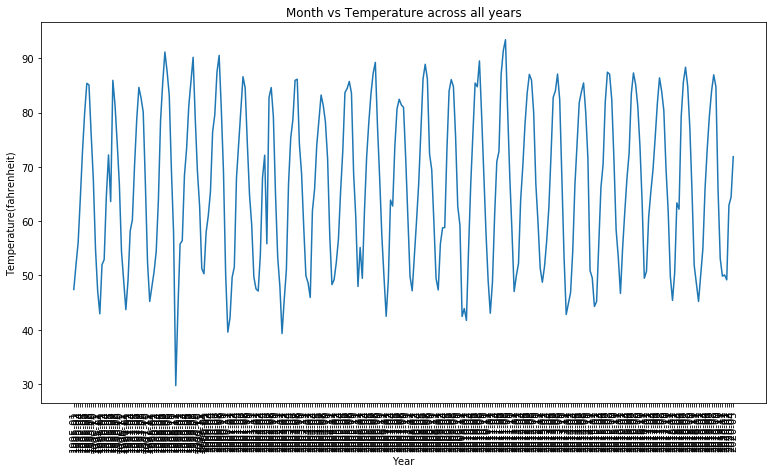

In [6]:
plt.figure(figsize=(13,7))
plt.plot(test_)
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Temperature(fahrenheit)')
plt.title('Month vs Temperature across all years')

Text(0.5, 1.0, 'Month vs Temperature across 1995-1989')

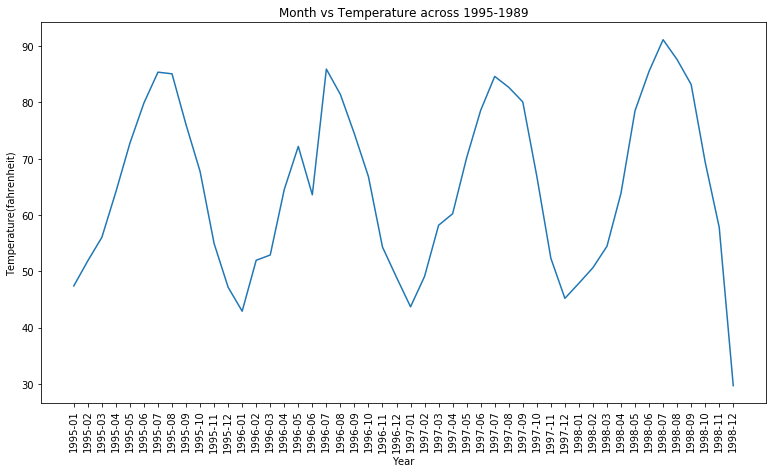

In [7]:
plt.figure(figsize=(13,7))
plt.plot(test_[0:48])
plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Temperature(fahrenheit)')
plt.title('Month vs Temperature across 1995-1989')


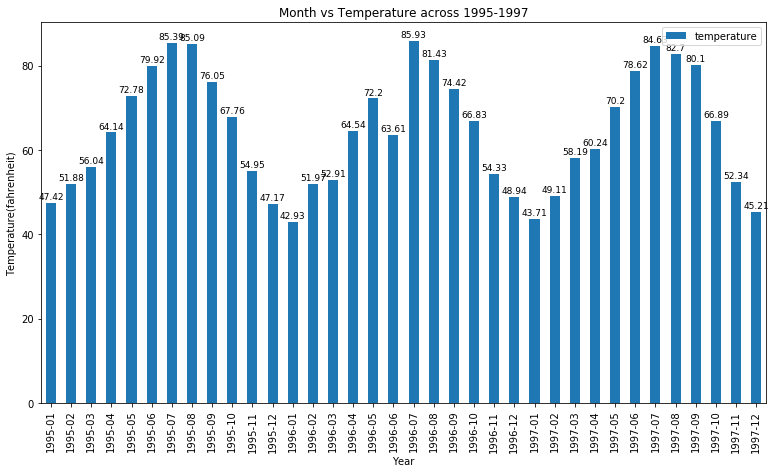

In [8]:
ax = test_[0:36].plot(kind='bar', figsize=(13,7), rot=0, title='RMSE scores')

plt.xlabel('Year')
plt.xticks(rotation=90)
plt.ylabel('Temperature(fahrenheit)')
plt.title('Month vs Temperature across 1995-1997')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2, p.get_height()+1), 
                ha='center', va='center', xytext=(0, 2), 
                textcoords='offset points', fontsize=9, color='black')

In [9]:
temperature_data = test_
temperature_data.rename(columns={ "temperature":"data_"},inplace=True)
test_temperature_data = temperature_data.ix['2018-01': '2020-05']
temperature_data = temperature_data.ix[: '2017-12']
temperature_data = temperature_data.round(5)

In [10]:
temperature_data.shape

(276, 1)

In [11]:
test_temperature_data.shape

(29, 1)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(temperature_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

## <center> Artificial Neural Networks </center>

- Artificial neural networks (ANNs) approach has been suggested as an alternative technique to time series forecasting and it gained immense popularity in last few years.
- ANNs try to recognize regularities and patterns in the input data, learn from experience and then provide generalized results based on their known previous knowledge.
- ANNs have been applied in many different areas, especially for forecasting and classification purposes.
- ANNs are data-driven and self-adaptive in nature. There is no need to specify a particular model form or to make any a priori assumption about the statistical distribution of the data.
- ANNs are inherently non-linear, which makes them more practical and accurate in modeling complex data patterns, as opposed to various traditional linear approaches, such as ARIMA methods.
- Finally, Neural Networks are universal approximaters. 

### Functions required

In [13]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [14]:
def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

In [15]:
# def plot_keras_model(model, show_shapes=True, show_layer_names=True):
#     return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names).create(prog='dot',format='svg'))

In [16]:
def get_combinations(parameters):
    return list(itertools.product(*parameters))

### Create a Neural Network

In [17]:
def create_NN(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(Dense(int(hidden_nodes), input_dim=int(input_nodes)))
    model.add(Dense(int(output_nodes)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### Train model

In [18]:
def train_model(model, X_train, y_train, epochs, batch_size):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)
    return model

In [19]:
def reshape_arrays(X_train, y_train):
    X_train = np.array(X_train)
    y_train = np.reshape(y_train, (len(y_train), 1))
    return X_train, y_train

## <center> Feed forward ANN </center>
- The most widely used ANNs in forecasting problems are multi-layer perceptrons (MLPs), which use a single hidden layer feed forward network(FNN).
- The model is characterized by a network of three layers, viz. input, hidden and output layer. There may be more than one hidden layer.

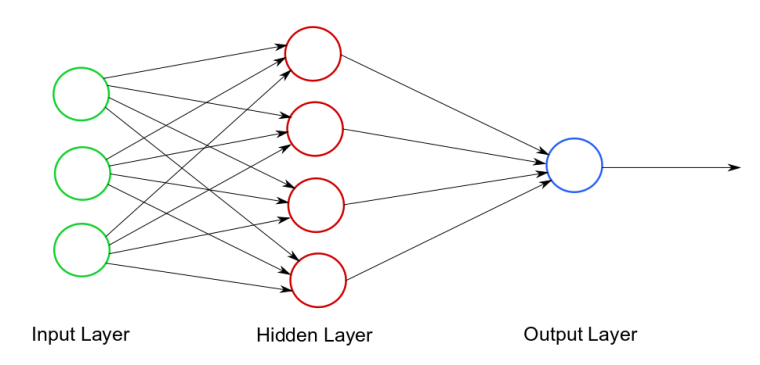

- Here, the output(y_t) depends on the previous 'p' time steps.
- So, the output layer consists of one unit and input layer layer consists of p units.
- We need to train the model with different number of units in all layers and select the parameters that gives the low RMSE score on test data.

### FNN - Preprocess data: Convert time series into suitable format

In [20]:
def preprocess_FNN(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back):
        x = data[i:look_back+i][::-1]
        y = data[look_back+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    return X_train, y_train, input_seq_for_test

### FNN - Forecast next 'n' timesteps

In [21]:
def forecast_FNN(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0] = np.append(forecasted_value, input_sequence[0][:-1])
    return forecasted_values

### Feed forward Network

In [22]:
def FNN(data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_FNN = preprocess_FNN(data, look_back)
    X_train, y_train = reshape_arrays(X_train, y_train)

    model_FNN = create_NN(input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    model_FNN = train_model(model_FNN, X_train, y_train, epochs, batch_size)

    input_seq_for_test_FNN = np.reshape(input_seq_for_test_FNN, (1, len(input_seq_for_test_FNN)))
    forecasted_values_FNN = forecast_FNN(model_FNN, input_sequence=input_seq_for_test_FNN, future_steps=future_steps)
    
    forecasted_values_FNN = list(scaler.inverse_transform([forecasted_values_FNN])[0])
    
    return model_FNN, forecasted_values_FNN

### FNN - Get scores on test data

In [23]:
def get_accuracies_FNN(temperature_data, test_temperature_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_FNN = []
    iterator = 0
    print('FNN - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if (iterator+1) != len(combination_of_params):
            print(iterator+1, end=' -> ')
        else:
            print(iterator+1)
        iterator = iterator+1

        look_back = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_FNN, forecasted_values_FNN = FNN(temperature_data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler)
        
        y_true = test_temperature_data.ix[:future_steps].data_
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_FNN)
        
        info = list(param) + [mse, mae, rmse] + forecasted_values_FNN
        information_FNN.append(info)

    information_FNN_df = pd.DataFrame(information_FNN)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_FNN_df.columns = ['look_back', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'RMSE'] + indexes
    return information_FNN_df

## <center> Time lagged Neural Networks </center>
- In FNN, y_t is a function of previous "p" time steps.
- TLNN is another variation of FNN and it also widely used.
- In TLNN, the input nodes are the time series values at some particular lags. For example, a typical TLNN for a time series, with seasonal period s = 12 can contain the input nodes as the lagged values at time t − 1 , t − 2 and t − 12 . The value at time t is to be forecasted using the values at lags 1, 2 and 12 as shiwn in the figure.

![TLNN](https://i.imgur.com/YFrPyRi.png)

### TLNN - Preprocess data: Convert time series into suitable format

In [24]:
def preprocess_TLNN(data, time_lagged_points):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(max(time_lagged_points), data.shape[0]):
        x = [data[i-p] for p in time_lagged_points]
        y = data[i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = [data[i+1-p] for p in time_lagged_points]
    return X_train, y_train, input_seq_for_test

### TLNN - Forecast next 'n' timesteps

In [25]:
def forecast_TLNN(model, time_lagged_points, last_sequence, future_steps):
    forecasted_values = []
    max_lag = max(time_lagged_points)
    for i in range(future_steps):
        input_sequence = [last_sequence[max_lag - p] for p in time_lagged_points]
        forecasted_value = model.predict(np.reshape(input_sequence, (1, len(input_sequence))))
        forecasted_values.append(forecasted_value[0][0])
        last_sequence = last_sequence[1:] + [forecasted_value[0][0]]
    return forecasted_values

### Time Lagged Neural Networks

In [26]:
def TLNN(data, time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_TLNN = preprocess_TLNN(data, time_lagged_points)
    X_train, y_train = reshape_arrays(X_train, y_train)
    model_TLNN = create_NN(input_nodes=len(time_lagged_points), hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    model_TLNN = train_model(model_TLNN, X_train, y_train, epochs, batch_size)

    max_lag = max(time_lagged_points)
    forecasted_values_TLNN = forecast_TLNN(model_TLNN, time_lagged_points, 
                                      list(data[-max_lag:]), future_steps=future_steps)
    forecasted_values_TLNN = list(scaler.inverse_transform([forecasted_values_TLNN])[0])
    
    return model_TLNN, forecasted_values_TLNN

### TLNN - Get scores on test data

In [27]:
def get_accuracies_TLNN(temperature_data, test_temperature_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_TLNN = []
    iterator = 0
    print('TLNN - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if (iterator+1) != len(combination_of_params):
            print(iterator+1, end=' -> ')
        else:
            print(iterator+1)
        iterator = iterator+1

        time_lagged_points = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_TLNN, forecasted_values_TLNN = TLNN(temperature_data, time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler)
        
        y_true = test_temperature_data.ix[:future_steps].data_
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_TLNN)
        
        info = list(param) + [mse, mae, rmse] + forecasted_values_TLNN
        information_TLNN.append(info)

    information_TLNN_df = pd.DataFrame(information_TLNN)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_TLNN_df.columns = ['look_back_lags', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'RMSE'] + indexes
    return information_TLNN_df

## <center> Seasonal Artificial Neural Networks </center>
- The SANN structure is proposed to improve the forecasting performance of ANNs for seasonal time series data.
- SANN can learn the seasonal pattern in the series, without removing them, contrary to some other traditional approaches, such as SARIMA.
- In this model, the seasonal parameter "s" is used to determine the number of input and output neurons.
- The i th and (i+1) th seasonal period observations are respectively used as the values of input and output neurons in this network structure.
- Thus while forecasting with SANN, the number of input and output neurons should be taken as 12 for monthly and 4 for quarterly time series. The appropriate number of hidden nodes can be determined by performing suitable experiments on the training data.

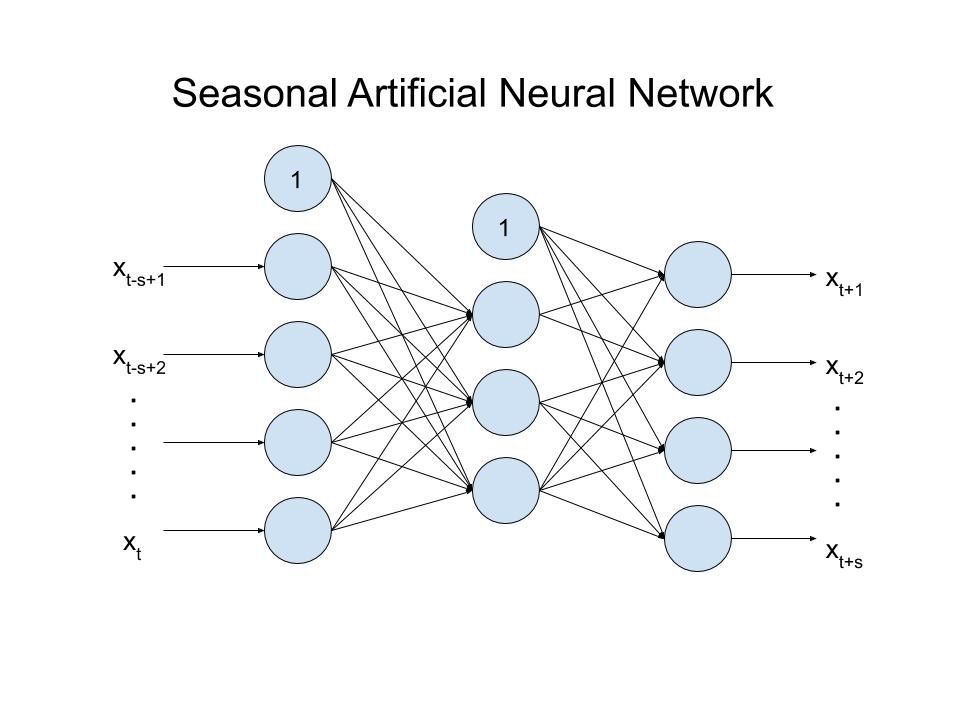

### SANN - Preprocess data: Convert time series into suitable format

In [28]:
def preprocess_SANN(data, seasonal_period):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(seasonal_period, data.shape[0]-seasonal_period+1):
        x = data[i-seasonal_period:i][::-1]
        y = data[i:i+seasonal_period]
        X_train.append(list(x))
        y_train.append(list(y))
    input_seq_for_test = data[i+1-seasonal_period:i+1][::-1]
    return X_train, y_train, input_seq_for_test

### SANN - Forecast next 'n' timesteps

In [29]:
def forecast_SANN(model, input_sequence, seasonal_period, future_steps):
    iterations = future_steps/seasonal_period
    forecasted_values = []
    for i in range(int(iterations) + 1):
        next_forecasted_values = model.predict(input_sequence)
        forecasted_values += list(next_forecasted_values[0])
        input_sequence = next_forecasted_values
    return forecasted_values[:future_steps]

### Seasonal Artificial  Neural Networks

In [30]:
def SANN(data, seasonal_period, hidden_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_SANN = preprocess_SANN(data, seasonal_period)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    input_seq_for_test_SANN = np.reshape(input_seq_for_test_SANN, (1, len(input_seq_for_test_SANN)))
    model_SANN = create_NN(input_nodes=seasonal_period, hidden_nodes=hidden_nodes, output_nodes=seasonal_period)
    model_SANN = train_model(model_SANN, X_train, y_train, epochs, batch_size)
    
    forecasted_values_SANN = forecast_SANN(model_SANN, input_seq_for_test_SANN, seasonal_period, future_steps=future_steps)
    forecasted_values_SANN = list(scaler.inverse_transform([forecasted_values_SANN])[0])
    return model_SANN, forecasted_values_SANN

### SANN - Get scores on test data

In [31]:
def get_accuracies_SANN(temperature_data, test_temperature_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_SANN = []
    iterator = 0
    print('SANN - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if (iterator+1) != len(combination_of_params):
            print(iterator+1, end=' -> ')
        else:
            print(iterator+1)
        iterator = iterator+1

        seasonal_period = param[0]
        hidden_nodes = param[1]
        epochs = param[2]
        batch_size = param[3]
        future_steps = param[4]

        model_SANN, forecasted_values_SANN = SANN(temperature_data, seasonal_period, hidden_nodes, epochs, batch_size, future_steps, scaler)
        
        y_true = test_temperature_data.ix[:future_steps].data_
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_SANN)
        
        info = list(param) + [mse, mae, rmse] + forecasted_values_SANN
        information_SANN.append(info)

    information_SANN_df = pd.DataFrame(information_SANN)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_SANN_df.columns = ['seasonal_period', 'hidden_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'RMSE'] + indexes
    return information_SANN_df

## <center> Long Short Term Memory(LSTM) </center>
- RNN’s are able to remember important things about the input they received, which enables them to be very precise in predicting what’s coming next. This is the reason why they are used for time series, speech recognition, text prediction,..etc.
- LSTM is a very powerful model that is used for sequential data.
- It has the power to store long term dependencies in it's memory.
- In a RNN/LSTM, the information cycles through a loop. When it makes a decision, it takes into consideration the current input and also what it has learned from the inputs it received previously.
- Here, the previous "p" timesteps are used to predict the current timestep as shown in the figure.
- We can also increase number of hidden units, Increase the number of units at the output.

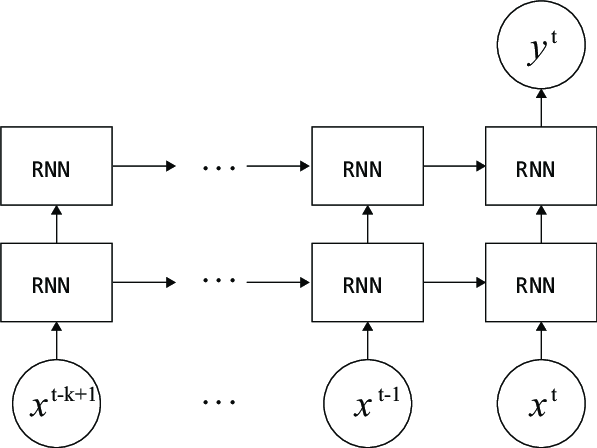

### LSTM - Create LSTM network

In [32]:
def create_LSTM(input_nodes, hidden_nodes, output_nodes):
    model = Sequential()
    model.add(LSTM(hidden_nodes, input_shape=(1, input_nodes)))
    model.add(Dense(output_nodes))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### LSTM - Preprocess data: Convert time series into suitable format

In [33]:
def preprocess_LSTM(data, look_back):
    data = np.array(data)[:, 0]
    X_train = []
    y_train = []
    for i in range(data.shape[0]-look_back):
        x = data[i:look_back+i][::-1]
        y = data[look_back+i]
        X_train.append(list(x))
        y_train.append(y)
    input_seq_for_test = data[i+1:look_back+i+1][::-1]
    return X_train, y_train, input_seq_for_test

### LSTM - Forecast next 'n' timesteps

In [34]:
def forecast_LSTM(model, input_sequence, future_steps):
    forecasted_values = []
    for i in range(future_steps):
        forecasted_value = model.predict(input_sequence)
        forecasted_values.append(forecasted_value[0][0])
        input_sequence[0][0] = np.append(forecasted_value, input_sequence[0][0][:-1])
    return forecasted_values

### Long Short Term Memory

In [35]:
def Long_Short_Term_Memory(data, look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler):
    data = scaler.transform(data)
    X_train, y_train, input_seq_for_test_LSTM = preprocess_LSTM(data, look_back)
    X_train = np.reshape(X_train, (len(X_train), 1, look_back))

    model_LSTM = create_LSTM(input_nodes=look_back, hidden_nodes=hidden_nodes, output_nodes=output_nodes)
#     plot_keras_model(model_LSTM)
    model_LSTM = train_model(model_LSTM, X_train, y_train, epochs, batch_size)

    input_seq_for_test_LSTM = np.reshape(input_seq_for_test_LSTM, (1, 1, len(input_seq_for_test_LSTM)))
    forecasted_values_LSTM = forecast_LSTM(model_LSTM, input_sequence=input_seq_for_test_LSTM, future_steps=future_steps)
    
    forecasted_values_LSTM = list(scaler.inverse_transform([forecasted_values_LSTM])[0])
    
    return model_LSTM, forecasted_values_LSTM

### LSTM - Get scores on test data

In [36]:
def get_accuracies_LSTM(temperature_data, test_temperature_data, parameters, scaler):
    combination_of_params = get_combinations(parameters)
    information_LSTM = []
    iterator = 0
    print('LSTM - Number of combinations: ' + str(len(combination_of_params)))
    
    for param in combination_of_params:
        if (iterator+1) != len(combination_of_params):
            print(iterator+1, end=' -> ')
        else:
            print(iterator+1)
        iterator = iterator+1

        input_nodes = param[0]
        hidden_nodes = param[1]
        output_nodes = param[2]
        epochs = param[3]
        batch_size = param[4]
        future_steps = param[5]

        model_LSTM, forecasted_values_LSTM = Long_Short_Term_Memory(temperature_data, input_nodes, hidden_nodes, output_nodes, epochs, batch_size, future_steps, scaler)
        
        y_true = test_temperature_data.ix[:future_steps].data_
        mse, mae, mape, rmse = calculate_performance(y_true, forecasted_values_LSTM)
        
        info = list(param) + [mse, mae, rmse] + forecasted_values_LSTM
        information_LSTM.append(info)

    information_LSTM_df = pd.DataFrame(information_LSTM)
    indexes = [str(i) for i in list(range(1, future_steps+1))]
    information_LSTM_df.columns = ['look_back', 'hidden_nodes', 'output_nodes', 'epochs', 'batch_size', 'future_steps', 'MSE', 'MAE', 'RMSE'] + indexes
    return information_LSTM_df

## Analyze the test data and forecasted data
- Plot the actual and forecasted values.
- Display optimal parameters.

In [37]:
def analyze_results(data_frame, test_temperature_data, name, flag=False):
    optimized_params = data_frame.iloc[data_frame.RMSE.argmin]
    future_steps = optimized_params.future_steps
    forecast_values = optimized_params[-1*int(future_steps):]
    y_true = test_temperature_data.ix[:int(future_steps)]
    forecast_values.index = y_true.index
    
    print('=== Best parameters of ' + name + ' ===\n')
    if (name == 'FNN' or name == 'LSTM'):
        model = create_NN(optimized_params.look_back, 
                          optimized_params.hidden_nodes, 
                          optimized_params.output_nodes)
        print('Input nodes(p): ' + str(optimized_params.look_back))
        print('Hidden nodes: ' + str(optimized_params.hidden_nodes))
        print('Output nodes: ' + str(optimized_params.output_nodes))
    elif (name == 'TLNN'):
        model = create_NN(len(optimized_params.look_back_lags), 
                          optimized_params.hidden_nodes, 
                          optimized_params.output_nodes)
        s = ''
        for i in optimized_params.look_back_lags:
            s = s+' '+str(i)
        print('Look back lags: ' + s)
        print('Hidden nodes: ' + str(optimized_params.hidden_nodes))
        print('Output nodes: ' + str(optimized_params.output_nodes))
    elif (name == 'SANN'):
        model = create_NN(optimized_params.seasonal_period, 
                          optimized_params.hidden_nodes, 
                          optimized_params.seasonal_period)
        print('Input nodes(s): ' + str(optimized_params.seasonal_period))
        print('Hidden nodes: ' + str(optimized_params.hidden_nodes))
        print('Output nodes: ' + str(optimized_params.seasonal_period))
        
    print('Number of epochs: ' + str(optimized_params.epochs))
    print('Batch size: ' + str(optimized_params.batch_size))
    print('Number of future steps forecasted: ' + str(optimized_params.future_steps))
    print('Mean Squared Error(MSE): ' + str(optimized_params.MSE))
    print('Mean Absolute Error(MAE): ' + str(optimized_params.MAE))
    print('Root Mean Squared Error(RMSE): ' + str(optimized_params.RMSE))
    print('\n\n')
    
    # Save model
    from keras.utils import plot_model
#     plot_model(model, to_file = STORAGE_FOLDER + name + '_best_fit_model.png', show_shapes=True, show_layer_names=True)
    
    # Save data
    data_frame.to_csv(STORAGE_FOLDER + name + '_information.csv')
    optimized_params.to_csv(STORAGE_FOLDER + name + '_optimized_values.csv')
    
    plt.figure(figsize=(10,5))
    plt.plot(y_true, color='green', label='Actual values')
    plt.plot(forecast_values, color='red', label='Forecasted values')
    plt.xlabel('Year')
    plt.xticks(rotation=90)
    plt.ylabel('Monthly mean Temperature')
    plt.legend(loc='best')
    if (flag==False):
        plt.title(name + ' - Comaprison: Actual vs Forecasted')
        plt.savefig(STORAGE_FOLDER + name + '_best_forecast'  + '.png')
    else:
        plt.title('Best of all: ' + name + ' - Comaprison: Actual vs Forecasted')
        plt.savefig(STORAGE_FOLDER + 'BEST_FORECAST_' + name + '.png')
    
    return optimized_params

## Pick the best method

In [38]:
def best_of_all(list_of_methods):
    RMSE_values = [x.RMSE for x in list_of_methods]
    index = np.argmin(RMSE_values)
    if (index==0):
        name = 'FNN'
    elif (index == 1):
        name = 'TLNN'
    elif (index == 2):
        name = 'SANN'
    else:
        name = 'LSTM'
    print(RMSE_values)
    
    names = ['FNN', 'TLNN', 'SANN', 'LSTM']
    RMSE_info = pd.Series(RMSE_values, index=names)
    
    print('Overall Best method on this data is ' + name)
    return index, name, RMSE_info

## Compare the results of above algorithms based on RMSE score.
- Plots a bar plot comparing the scores of different algorithms.

In [39]:
def compare_ANN_methods(temperature_data, test_temperature_data, scaler, parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps):
    
    information_FNN_df = get_accuracies_FNN(temperature_data, test_temperature_data, parameters_FNN, scaler)
    optimized_params_FNN = analyze_results(information_FNN_df, test_temperature_data, 'FNN')
    
    information_TLNN_df = get_accuracies_TLNN(temperature_data, test_temperature_data, parameters_TLNN, scaler)
    optimized_params_TLNN = analyze_results(information_TLNN_df, test_temperature_data, 'TLNN')
    
    information_SANN_df = get_accuracies_SANN(temperature_data, test_temperature_data, parameters_SANN, scaler)
    optimized_params_SANN = analyze_results(information_SANN_df, test_temperature_data, 'SANN')
    
    information_LSTM_df = get_accuracies_LSTM(temperature_data, test_temperature_data, parameters_LSTM, scaler)
    optimized_params_LSTM = analyze_results(information_LSTM_df, test_temperature_data, 'LSTM')
    
    list_of_methods = [optimized_params_FNN, optimized_params_TLNN, optimized_params_SANN, optimized_params_LSTM]
    information = [information_FNN_df, information_TLNN_df, information_SANN_df, information_LSTM_df]
    
    index, name, RMSE_info = best_of_all(list_of_methods)
    best_optimized_params = analyze_results(information[index], test_temperature_data, name, True)
    
    return RMSE_info

## Number of future steps to be forecasted

In [40]:
future_steps = 28

## Initialize all the parameters
- It tries all the combinations of different parameters and selects the optimal parmaters based on the RMSE scores.
- It also finds the best method for this data.

In [41]:
# # look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
# parameters_FNN = [[1,2,3,6,8,10,12], [3,4,5,6], [1], [500], [20], [future_steps]]

# # time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
# parameters_TLNN = [[[1,2,3,11,12], [1,2,3,4,11,12], [1,2,3,11,12,13], [1,2,3,4,5,6,10,11,12]], [3,4,5,6], [1], [300], [20], [future_steps]]

# # seasonal_period, hidden_nodes, epochs, batch_size, future_steps
# parameters_SANN = [[12], [3,4,5,6,7,8,9,10], [500], [20], [future_steps]]

# # look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
# parameters_LSTM = [[1,2,3,4,5,6,7,8,9,10,11,12,13], [3,4,5,6], [1], [300], [20], [future_steps]]

# RMSE_info = compare_ANN_methods(temperature_data, test_temperature_data, scaler, 
#                     parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps)

FNN - Number of combinations: 12
1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 11 -> 12
=== Best parameters of FNN ===

Input nodes(p): 8.0
Hidden nodes: 5.0
Output nodes: 1.0
Number of epochs: 50.0
Batch size: 20.0
Number of future steps forecasted: 28.0
Mean Squared Error(MSE): 21.547
Mean Absolute Error(MAE): 3.631
Root Mean Squared Error(RMSE): 4.642



TLNN - Number of combinations: 16
1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 11 -> 12 -> 13 -> 14 -> 15 -> 16
=== Best parameters of TLNN ===

Look back lags:  1 2 11 12
Hidden nodes: 4
Output nodes: 1
Number of epochs: 30
Batch size: 20
Number of future steps forecasted: 28
Mean Squared Error(MSE): 50.632
Mean Absolute Error(MAE): 5.237
Root Mean Squared Error(RMSE): 7.116



SANN - Number of combinations: 8
1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8
=== Best parameters of SANN ===

Input nodes(s): 12.0
Hidden nodes: 8.0
Output nodes: 12.0
Number of epochs: 50.0
Batch size: 20.0
Number of future steps forecasted: 28.0
Mean S

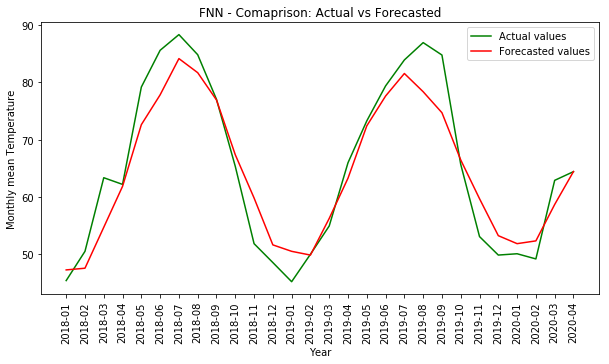

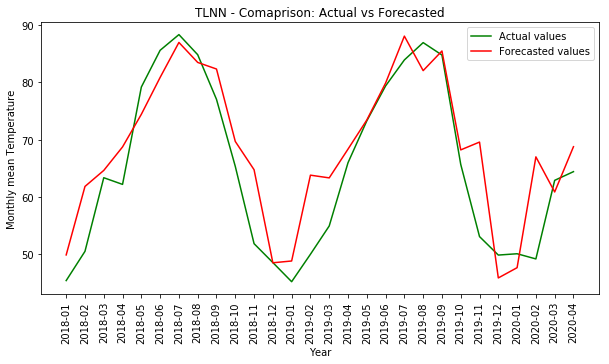

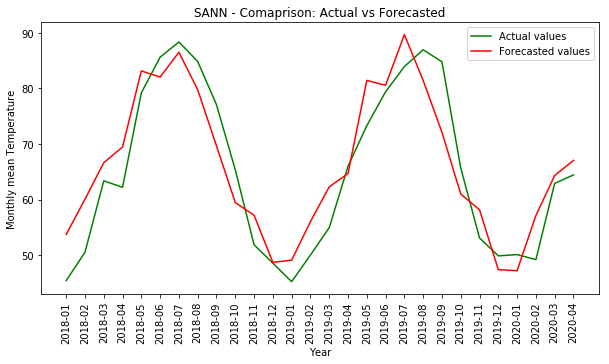

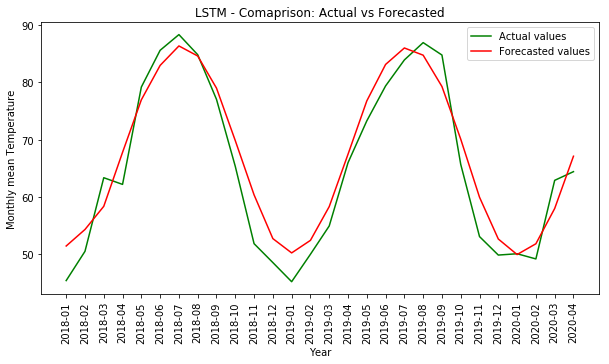

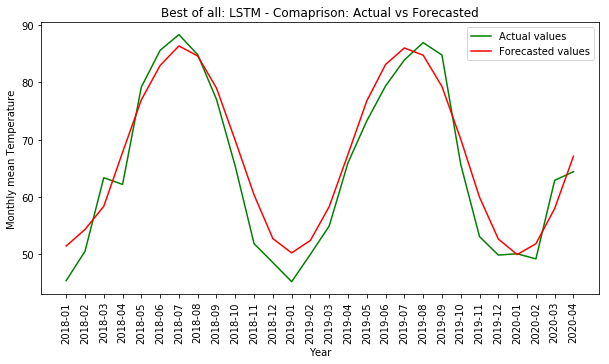

In [42]:
# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_FNN = [[3,6,8,12], [3,5,6], [1], [50], [20], [future_steps]]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[[1,2,11,12], [1,2,3,12], [1,2,12,13], [1,2,10,11,12]], [3,4,5,6], [1], [30], [20], [future_steps]]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6,7,8,9,10], [50], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[1,2,3,4,12,13], [3,4,5,6], [1], [30], [20], [future_steps]]

RMSE_info = compare_ANN_methods(temperature_data, test_temperature_data, scaler, 
                    parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps)

In [43]:
RMSE_info

FNN     4.642
TLNN    7.116
SANN    5.768
LSTM    4.055
dtype: float64

## Plot RMSE scores

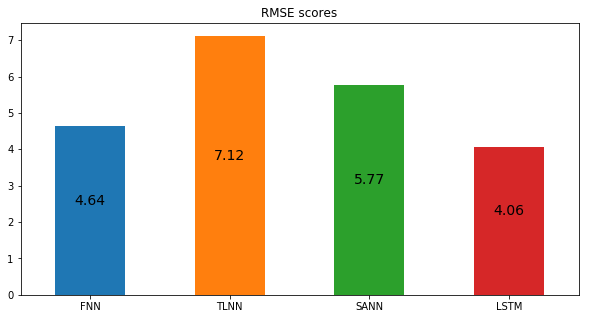

In [44]:
ax = RMSE_info.plot(kind='bar', figsize=(10,5), rot=0, title='RMSE scores')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2, p.get_height()*0.5), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=14, color='black')

- If we compare the results, LSTM worked better than all the methods on this data.

### NOTE:
- This is an automated code that takes the parameters as input and it tries with all combonations of parameters and selects the best method from all of them based on RMSE scores.
- It stores MSE, RMSE, parameters for all the combinations along with the forecasted values in a csv file for future reference. Also, the plots that are shown above are also stored. Change the STORAGE_FOLDER accordingly.
- Change the data and run the code. It's as simple as that.

### References:
- An Introductory Study on Time Series Modeling and Forecasting - https://arxiv.org/abs/1302.6613